# Boston Maraton Clustering Challenge

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools

## Data

Dataset found at https://github.com/llimllib/bostonmarathon as collected from baa.org.  <br>
Selected information is from 2012 for runners of the Boston Marathon

In [2]:
# Boston Marathon data from 2012
raw2012 = pd.read_csv('~/Desktop/Data_Science/Boston_Marathon_2012.csv')

In [3]:
raw2012.head(10)

,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
0,4 / 26,"Soejima, Masazumi",Fukuoka City,M,41,83.45,W1,4 / 35,NaN,4 / 26,83.45,JPN
1,14 / 4335,"Gebremariam, Gebregziabher",Tigray,M,27,142.93,2,14 / 21616,NaN,14 / 12621,142.93,ETH
2,6 / 26,"Van Dyk, Ernst F.",Paarl,M,39,84.38,W2,6 / 35,NaN,6 / 26,84.38,RSA
3,2 / 26,"Fearnley, Kurt H.",Hamilton,M,31,81.65,W3,2 / 35,NaN,2 / 26,81.65,AUS
4,3 / 26,"Hokinoue, Kota",Iizuka,M,38,83.43,W4,3 / 35,NaN,3 / 26,83.43,JPN
5,2 / 4335,"Matebo, Levy",Trans Nzoia,M,22,133.10,4,2 / 21616,NaN,2 / 12621,133.10,KEN
6,1 / 4599,"Cherop, Sharon",Marakwet,F,28,151.83,F4,28 / 21616,NaN,1 / 8995,151.83,KEN
7,5 / 4335,"Chebet, Wilson",Marakwet,M,26,134.93,5,5 / 21616,NaN,5 / 12621,134.93,KEN
8,1 / 26,"Cassidy, Joshua R.",Toronto,M,27,78.42,W5,1 / 35,ON,1 / 26,78.42,CAN
9,5 / 26,"Schabort, Krige",Cedartown,M,48,83.73,W6,5 / 35,GA,5 / 26,83.73,USA


In [4]:
raw2012.shape

(21652, 12)

In [5]:
raw2012.describe()

,age,net
count,21652.000000,21652.00000
mean,41.836135,258.64258
std,10.858308,49.94535
min,18.000000,78.42000
25%,33.000000,224.63000
50%,42.000000,251.07500
75%,50.000000,285.53000
max,83.000000,570.27000


In [6]:
raw2012['official'].value_counts()

-         76
266.43    10
239.08    10
243.47    10
232.00    10
238.55    10
248.20    10
238.68     9
236.23     9
237.43     9
275.18     9
266.25     9
237.90     9
233.30     9
260.77     9
245.33     8
259.55     8
221.97     8
259.00     8
250.12     8
252.07     8
239.93     8
232.77     8
263.87     8
256.00     8
237.55     8
274.02     8
224.90     8
246.92     8
234.97     8
          ..
357.12     1
194.28     1
272.87     1
345.82     1
191.20     1
225.50     1
191.43     1
167.93     1
370.68     1
191.47     1
398.02     1
368.77     1
180.25     1
169.93     1
348.83     1
356.83     1
206.78     1
360.67     1
299.62     1
346.90     1
188.28     1
300.85     1
365.98     1
301.52     1
196.62     1
284.88     1
276.85     1
311.48     1
286.08     1
331.13     1
Name: official, Length: 9570, dtype: int64

In [7]:
raw2012.loc[raw2012['official'].str.contains("-"),'official'] = 0

raw2012['official'] = raw2012['official'].astype(np.float64)

In [8]:
#separate division column to two numerical columns
raw2012['div_rank'], raw2012['div'] = raw2012['division'].str.split(' / ', 1).str
raw2012['div_rank'] = raw2012['div_rank'].astype(np.float64)
raw2012['div'] = raw2012['div'].astype(np.float64)

In [9]:
#separate genderdiv column to two numerical columns
raw2012['gender_rank'], raw2012['gender_division'] = raw2012['genderdiv'].str.split(' / ', 1).str
raw2012['gender_rank'] = raw2012['gender_rank'].astype(np.float64)
raw2012['gender_division'] = raw2012['gender_division'].astype(np.float64)

In [10]:
raw2012.describe()

,age,official,net,div_rank,div,gender_rank,gender_division
count,21652.000000,21652.000000,21652.00000,21652.000000,21652.000000,21652.000000,21652.000000
mean,41.836135,261.875575,258.64258,1376.575790,2752.150748,5547.342324,11093.683817
std,10.858308,52.641530,49.94535,1182.365162,1516.672306,3374.529805,1842.143331
min,18.000000,0.000000,78.42000,1.000000,1.000000,1.000000,9.000000
25%,33.000000,228.377500,224.63000,439.000000,1521.000000,2689.000000,8995.000000
50%,42.000000,255.475000,251.07500,1039.000000,2255.000000,5395.500000,12621.000000
75%,50.000000,290.372500,285.53000,1949.000000,4335.000000,8102.000000,12621.000000
max,83.000000,475.320000,570.27000,4599.000000,4599.000000,12621.000000,12621.000000


In [11]:
boston2012 = pd.get_dummies(raw2012, columns=['gender'])

In [12]:
boston2012.describe()

,age,official,net,div_rank,div,gender_rank,gender_division,gender_F,gender_M
count,21652.000000,21652.000000,21652.00000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000
mean,41.836135,261.875575,258.64258,1376.575790,2752.150748,5547.342324,11093.683817,0.415851,0.584149
std,10.858308,52.641530,49.94535,1182.365162,1516.672306,3374.529805,1842.143331,0.492879,0.492879
min,18.000000,0.000000,78.42000,1.000000,1.000000,1.000000,9.000000,0.000000,0.000000
25%,33.000000,228.377500,224.63000,439.000000,1521.000000,2689.000000,8995.000000,0.000000,0.000000
50%,42.000000,255.475000,251.07500,1039.000000,2255.000000,5395.500000,12621.000000,0.000000,1.000000
75%,50.000000,290.372500,285.53000,1949.000000,4335.000000,8102.000000,12621.000000,1.000000,1.000000
max,83.000000,475.320000,570.27000,4599.000000,4599.000000,12621.000000,12621.000000,1.000000,1.000000


### Defining Data

In [13]:
list(boston2012)

['division',
 'name',
 'city',
 'age',
 'official',
 'bib',
 'overall',
 'state',
 'genderdiv',
 'net',
 'country',
 'div_rank',
 'div',
 'gender_rank',
 'gender_division',
 'gender_F',
 'gender_M']

In [14]:
X = boston2012.drop(['division', 'name', 'city', 'state', 'country', 'bib', 'overall', 'genderdiv',], 1)

X_norm = normalize(X)

## K-Means

### Elbow Plot

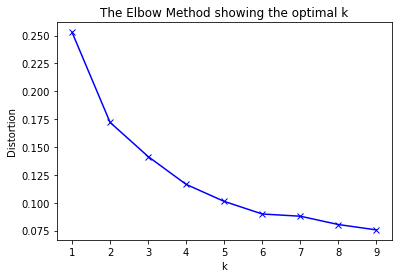

In [15]:
# determine k using elbow method

from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow plot of k values indicates 2 clusters,

Comparing results of clustering (using default settings) with K-Mean and Mini_Batch K-Means

In [16]:
# k-means using default settings
y_pred = KMeans(n_clusters=2).fit_predict(X_norm)

In [17]:
# mini-batch k-means with default settings
mini_y_pred = MiniBatchKMeans(n_clusters=2).fit_predict(X_norm)

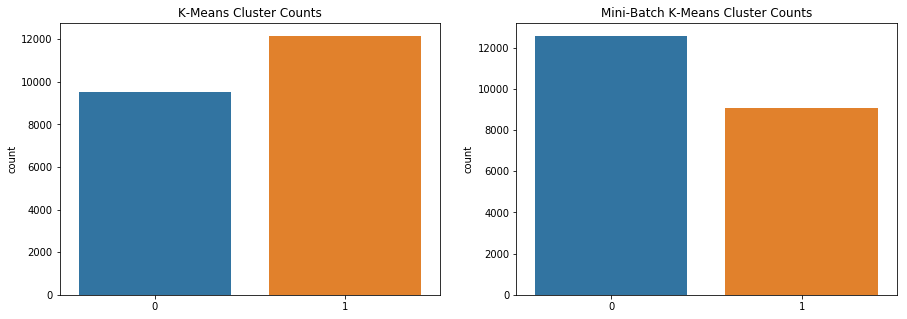

In [18]:
# Visualize cluster counts

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_pred, data=boston2012)
plt.title('K-Means Cluster Counts')

plt.subplot(1, 2, 2)
sns.countplot(x=mini_y_pred, data=boston2012)
plt.title('Mini-Batch K-Means Cluster Counts')

plt.show()

Both methods of K-Means clustering are creating similarly sized clusters (one is roughtly 10% larger than the other), so we'll focus on Mini-Batch K-Means to optimize computational efficiency.

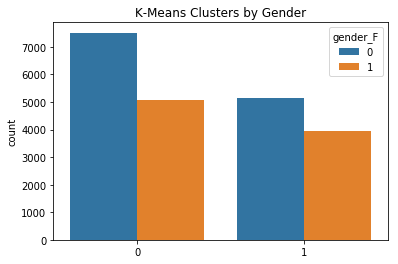

In [19]:
# Visualize clusters with binary feature of gender

sns.countplot(x=mini_y_pred, hue="gender_F", data=boston2012)
plt.title('K-Means Clusters by Gender')

plt.show()

It seems gender has little impact on the clusters as each cluster contains more male than female runners, with similar proportions in each group.

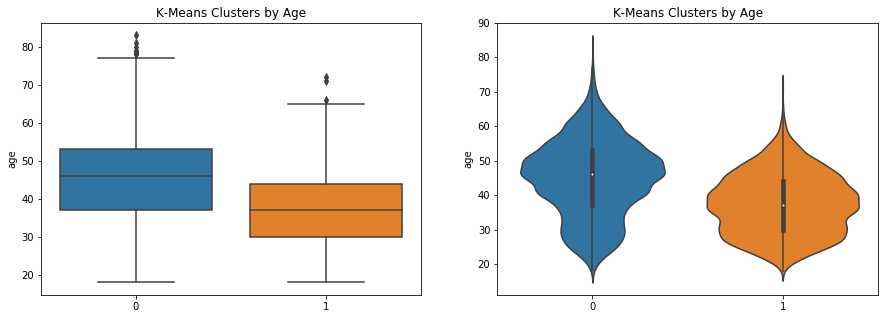

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="age", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters by Age')

plt.subplot(1, 2, 2)
sns.violinplot(y="age", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters by Age')

plt.show()

Both clusters include runners at the low end (age 18), but the high end is dominated by the second cluster, which includes the highest ages and a larger number of advanced ages.

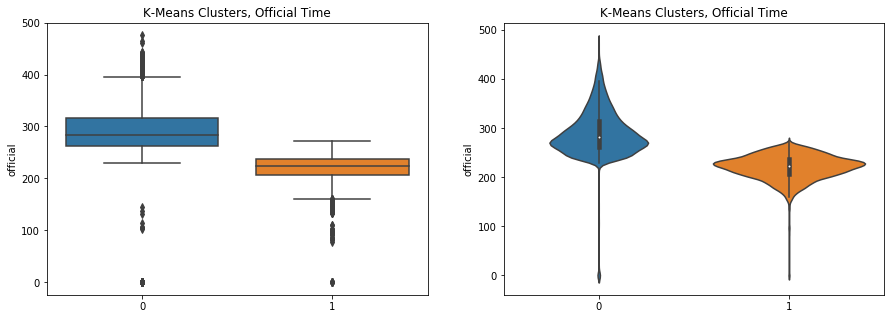

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="official", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Official Time')

plt.subplot(1, 2, 2)
sns.violinplot(y="official", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Official Time')

plt.show()

Exploring the Official Time variable values for each cluster, we see that the second cluster (group 1) has notably higher times.

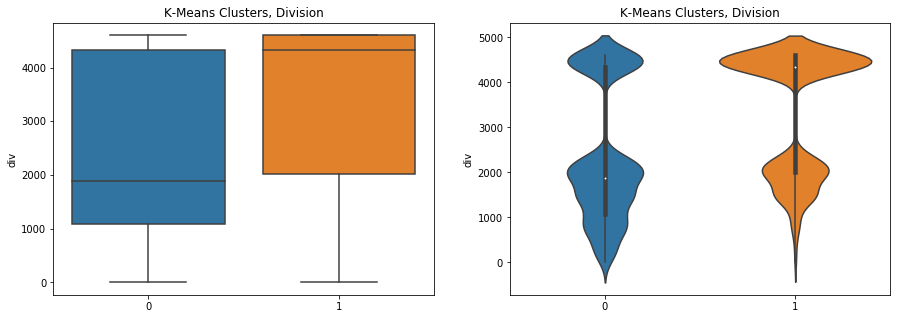

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="div", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Division')

plt.subplot(1, 2, 2)
sns.violinplot(y="div", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Division')

plt.show()

Examining the Division variable by cluster we find that one group has higher values than another, however each cluster shows a similar spread of values.  Each cluster contains runners from each division.

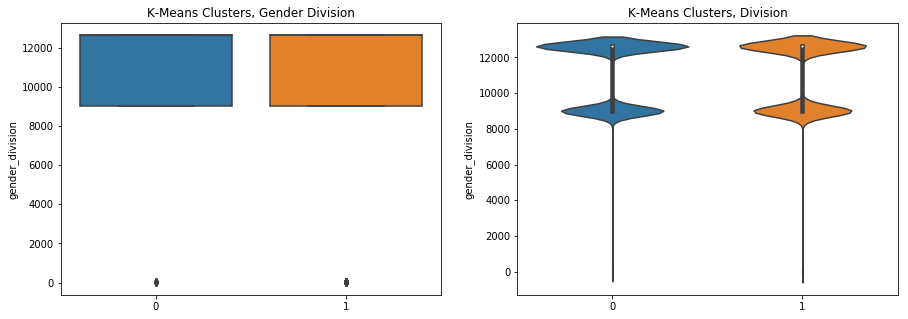

In [23]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="gender_division", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Gender Division')

plt.subplot(1, 2, 2)
sns.violinplot(y="gender_division", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Division')

plt.show()

The gender division feature is consistent between the two categories.

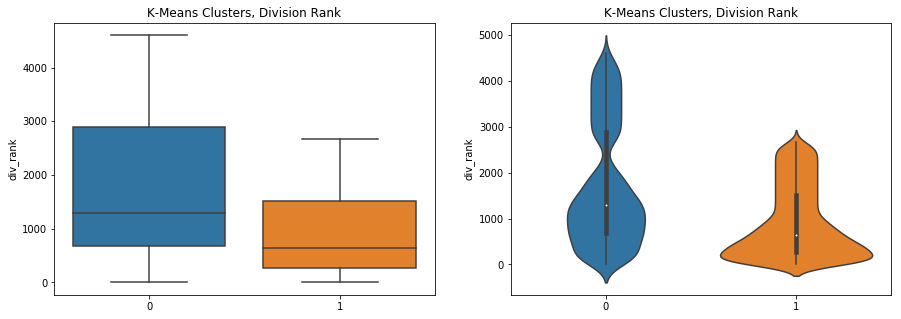

In [24]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="div_rank", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Division Rank')

plt.subplot(1, 2, 2)
sns.violinplot(y="div_rank", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Division Rank')

plt.show()

A look at the Division Rank for each clusters shows that the second cluster has records with lower ranks (larger numbers), due to the lowest ranks falling in this group alone.

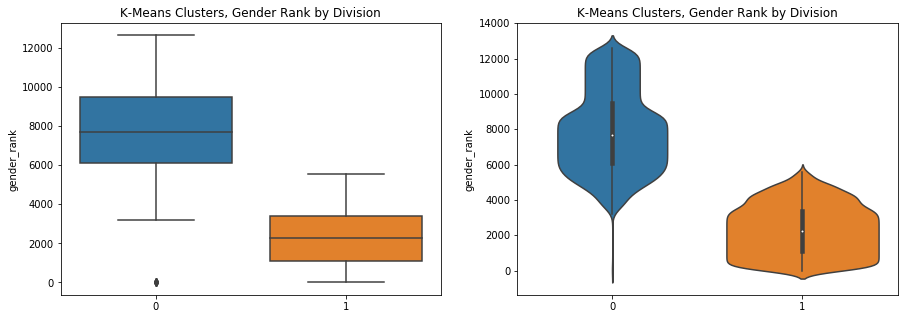

In [25]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="gender_rank", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Gender Rank by Division')

plt.subplot(1, 2, 2)
sns.violinplot(y="gender_rank", x=mini_y_pred, data=boston2012)
plt.title('K-Means Clusters, Gender Rank by Division')

plt.show()

Looking at the Gendered Division Rank shows a stronger difference between the two clusters, with the lowest half of rankings being entirely in the second group.

## Mean Shift

In [26]:
ms = MeanShift(bin_seeding=True)
ms.fit(X_norm)

predict=ms.fit_predict(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 2


Mean shift agrees with the elbow plot on 2 clusters for the data.  But does Mean Shift create similar clusters?

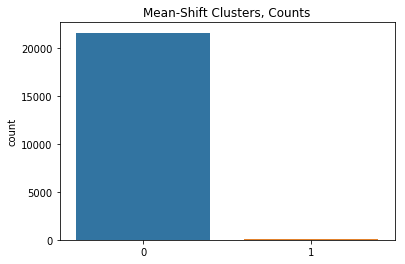

In [27]:
# Visualize clusters with binary feature of gender

sns.countplot(x=predict, data=boston2012)
plt.title('Mean-Shift Clusters, Counts')

plt.show()

Mean shift has generated one very large cluster and one very small cluster.  This doesn't seem like it will be very insightful.

Spectral Clustering and Afficnity Propgation were not able to execute on my machine, so we'll stick with K-Means as the best option for this data.

## Conclusion

No one feature seems to dominate either cluster, with each cluster being comprised of a large range of values for each feature.  The association of official time and division rank (gendered or not) make for similar distributions of those variables in each cluster.  Age and Gender are also similarly represented in each cluster.  The defining features of each cluster seem to be how the individual values of those features interact in the record of the individual runners.